# git2net analysis for the networkx repository

First we import the required packages

In [429]:
import pygit2 as git2
import os
import shutil
import git2net
import pathpy as pp
import sqlite3
import pandas as pd
from datetime import date, datetime, timedelta
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import json 
import math
import copy
import networkx as nx
import random
from statistics import mean, stdev, StatisticsError
import gambit
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Bipartite networks
### Converting bipartite network into WOMP (weighted one-mode projection)

In [98]:
def collab_network(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, file_base=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))

        n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        
        n = remove_duplicate_filenames(n, git_repo_dir)
        n = add_weights(n, node_info)
        
        new_n = copy.deepcopy(n)

        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w = w + n.edges[(node1, file)]['wijLR']
                        if w > 0:
                            new_n.add_edge(node1, node2, weight=w)

        for node in n.nodes:
            if node_info['class'][node] == 'file':
                new_n.remove_node(node)

        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [99]:
def remove_duplicate_filenames(n, git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)

    new_n = copy.deepcopy(n)
    for node in new_n.nodes:
        if node in remove_files:
            n.remove_node(node)
    del new_n
    return n

In [100]:
def duplicate_filenames(git_repo_dir):
    all_files = []
    for path, subdirs, files in os.walk(git_repo_dir):
        for name in files:
            all_files.append(name)

    duplicates = [file for file in all_files if all_files.count(file) > 1]
    remove_files = set(duplicates)
    print(len(remove_files))
    
    #keep_nodes = [f for f in all_files if f not in remove_files]
    #print(len(keep_nodes))
    #print(keep_nodes)
    
    #t = t.filter_nodes(keep_nodes)

    #new_n = copy.deepcopy(n)
    #for node in new_n.nodes:
    #    if node in remove_files:
    #        n.remove_node(node)
    #del new_n
    return remove_files

In [101]:
def add_weights(n, node_info):
    for node in n.nodes:
        if node_info['class'][node] == 'author':
            s = 0
            for successor in n.successors[node]:
                for key in n.edges:
                    if key[0] == node and key[1] == successor:
                        s = s + n.edges[key]['weight']

        n.nodes[node]['WiL'] = s
    for edge in n.edges:
        n.edges[edge]['wijLR'] = n.edges[edge]['weight'] / n.nodes[edge[0]]['WiL']
    
    return n

In [102]:
def collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, min_date, max_date, duplicate_files, file_base=True, is_temp=True):
    if file_base:
        start = int(datetime.timestamp(min_date))
        end = int(datetime.timestamp(max_date))
        
        #print('1. From temporal network...')
        if is_temp:
            n = pp.Network.from_temporal_network(t, min_time=start, max_time=end)
        else:
            n = t
        
        #print('2. Remove duplicate files... SKIPPED')
        #n = remove_duplicate_filenames(n, git_repo_dir)
        
        #print('3. New empty network')
        new_n = pp.Network(directed=False)
        
        #print('4. Add authors to network')
        nn = copy.deepcopy(n.nodes)
        for node in nn:
            if node_info['class'][node] != 'file':
                new_n.add_node(node)
            elif node in duplicate_files:
                n.remove_node(node)
        
        #new_n = new_n.to_undirected()  
        
        #print('5. Jaccard loop')
        visited_nodes = []
        for node1 in n.nodes:
            if node_info['class'][node1] == 'author':
                for node2 in n.nodes:
                    if node_info['class'][node2] == 'author' and node1 != node2 and not node2 in visited_nodes:
                        intersect = n.successors[node1].intersection(n.successors[node2])
                        w_min = 0
                        w_max = 0
                        for file in intersect:
                            #print((node1, file), ':', n.edges[(node1, file)])
                            w_min = w_min + min(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                            w_max = w_max + max(n.edges[(node1, file)]['weight'], n.edges[(node2, file)]['weight'])
                        if w_max > 0:
                            new_n.add_edge(node1, node2, weight=w_min/w_max)
                visited_nodes.append(node1)
                
                
        return new_n
    else:
        n, node_info, edge_info = git2net.get_coauthorship_network(sqlite_db_file, time_from=min_date, time_to=max_date)
        return n

In [103]:
def pathpy_to_networkx(n):
    G = nx.Graph()
    for node in n.nodes:
        G.add_node(node)
    
    for n1, n2 in n.edges:
        G.add_edge(n1, n2, weight=n.edges[(n1, n2)]['weight'])
        
    return G

In [104]:
def network_stats_nx(G):
    d = {}

    degrees = dict(G.degree())

    clust_coeff = nx.clustering(G, weight='weight')

    deg_centrality = nx.degree_centrality(G)
    try:
        max_dc = max(deg_centrality.values())
    except ValueError:
        max_dc = 0
    sum_dc = 0    
    for node in deg_centrality:
        sum_dc = sum_dc + (max_dc - deg_centrality[node])
    
    G_n = nx.Graph()
    for node in G.nodes:
        G_n.add_node(node)
    for u,v,a in G.edges(data=True):
        G_n.add_edge(u,v, weight=a['weight']*(-1)+1)
    shortest_paths = nx.shortest_path_length(G_n, weight='weight')
    s_p = 0
    i = 0
    for start, targets in shortest_paths:
        s_p = s_p + sum(targets.values())
        i = i + len(targets.values())
    
    k_core = len([x for x in nx.core_number(G) if nx.core_number(G)[x] >= max(nx.core_number(G).values())*0.8])
    deg_c_core = len([x for x in deg_centrality if deg_centrality[x] >= max(deg_centrality.values())*0.8])
    
    x=[]
    y=[]
    for node in G.nodes:
        if not (G.degree[node] == 0 and clust_coeff[node] == 0):
            x.append(G.degree[node])
            y.append(clust_coeff[node])
    
    d['Number of nodes'] = G.number_of_nodes()
    d['Network density'] = nx.density(G)
    try:
        d['Mean degree'] = sum(degrees.values())/len(degrees.values())
    except ZeroDivisionError:
        d['Mean degree'] = 0
    if G.number_of_nodes() > 2:
        d['Degree centrality'] = sum_dc / (G.number_of_nodes() - 2)
    else:
        d['Degree centrality'] = 0
    try:
        d['Clustering coeff.'] = sum(clust_coeff.values())/len(clust_coeff.values())
    except ZeroDivisionError:
        d['Clustering coeff.'] = 0
    try:
        d['Mean path length'] = s_p / i
    except ZeroDivisionError:
        d['Mean path length'] = 0
    d['Connected components'] = nx.number_connected_components(G)
    d['K-Core count'] = k_core
    d['Degree centrality core'] = deg_c_core
    if G.number_of_nodes() > 0:
        d['Core/periphery (k-core)'] = k_core / G.number_of_nodes()
        d['Core/periphery (degree)'] = deg_c_core / G.number_of_nodes()
    else:
        d['Core/periphery (k-core)'] = 0
        d['Core/periphery (degree)'] = 0
    try:
        d['Hierarchy'] = np.polyfit(x, y, 1)[0]
    except TypeError:
        d['Hierarchy'] = 0
    
    return d

In [105]:
def generate_random_network(n, node_info):
    rnet = pp.Network(directed=True)
    files = [x for x in node_info['class'] if node_info['class'][x] == 'file' and x in n.nodes]
    #print(len(files))
    authors = [x for x in node_info['class'] if node_info['class'][x] == 'author' and x in n.nodes]
    #print(len(authors))
    
    for edge in n.edges:
        rnet.add_edge(random.choice(authors), random.choice(files))
    
    return rnet

# QUALITATIVE SECTION

In [199]:
def get_repo_details(repo):
    owner = repo.split('/')[0]
    name = repo.split('/')[1]
    
    sqlite_db_file = 'databases/{r}/{r2}.db'.format(r=repo.lower(), r2=name.lower())
    db = sqlite3.connect(sqlite_db_file)
    with open('edits_query.sql', 'r') as f:
        sql = f.read()
    edits = pd.read_sql_query(sql, db)
    
    db = sqlite3.connect('../../repo_tools/repo_tools/joci_releases_v3.db')
    with open('releases_query.sql', 'r') as f:
        sql = f.read().format(owner='\'' + owner + '\'', repo_name='\'' + name + '\'')
    releases = pd.read_sql_query(sql, db)
    
    with open('issues_query.sql', 'r') as f:
        sql = f.read().format(owner='\'' + owner + '\'', repo_name='\'' + name + '\'')
    issues = pd.read_sql_query(sql, db)
    
    
    with open('feature_keywords.json','r') as f:
        feature_keywords = json.load(f)

    with open('bug_keywords.json','r') as f:
        bug_keywords = json.load(f)

    with open('drop_words.json','r') as f:
        drop_words = json.load(f)

    issues['issue_title'] = issues['issue_title'].str.lower().str.replace('|'.join(drop_words),'', regex=True)

    issues['is_feature'] = issues['issue_title'].str.contains('|'.join(feature_keywords))
    issues['is_bug'] = issues['issue_title'].str.contains('|'.join(bug_keywords))

    issues['bug_or_feature'] = 'unknown'
    issues.loc[(issues['is_feature'] == True) & (issues['is_bug'] == False), 'bug_or_feature'] = 'feature'
    issues.loc[(issues['is_feature'] == False) & (issues['is_bug'] == True), 'bug_or_feature'] = 'bug'
    del issues['is_bug']
    del issues['is_feature']

    issues['created_at'] = pd.to_datetime(issues['created_at'], format='%Y-%m-%dT%H:%M:%SZ')
    issues['closed_at'] = pd.to_datetime(issues['closed_at'], format='%Y-%m-%dT%H:%M:%SZ')
    issues['open_for'] = issues['closed_at'] - issues['created_at']

    edits[pd.isnull(edits['lines_added']) | pd.isnull(edits['lines_removed'])] = 0 # Binary file changes have lines of NaN --> consider as 0 lines changed
    edits = edits.drop(edits[edits['hash'] == 0].index) # Sometimes the hash is 0, with all the other columns, and this leads to TypeError
    edits['author_date'] = pd.to_datetime(edits['author_date'], format='%Y-%m-%d %H:%M:%S')
    releases.sort_values(by=['created_at'])
    releases['created_at'] = pd.to_datetime(releases['created_at'], format='%Y-%m-%dT%H:%M:%SZ')
    releases['prev_created_at'] = releases.created_at.shift()
    releases['prev_tag_name'] = releases.tag_name.shift()
    
    versions = releases['tag_name'].str.extract(r'.*(\d+)\.(\d+)\.(\d+).*')
    #pd.isnull(versions)
    versions_prev = releases['prev_tag_name'].str.extract(r'.*(\d+)\.(\d+)\.(\d+).*')
    versions_prev[0] == versions[0]
    releases['release_type'] = 'unknown'
    releases.loc[(versions[0] != versions_prev[0]) & (pd.isnull(versions_prev[0]) == False) & (pd.isnull(versions[0]) == False), 'release_type'] = 'major'
    releases.loc[
        ((versions[0] == versions_prev[0]) | 
        (pd.isnull(versions_prev[0]) == True)) &
        ((versions[1] != versions_prev[1]) &
        (pd.isnull(versions_prev[1]) == False)),
        'release_type'
    ] = 'minor'
    releases.loc[
        ((versions[0] == versions_prev[0]) | 
        (pd.isnull(versions_prev[0]) == True)) & 
        ((versions[1] == versions_prev[1]) | 
        (pd.isnull(versions_prev[1]) == True)) & 
        ((versions[2] != versions_prev[2]) & 
        (pd.isnull(versions_prev[2]) == False)), 
        'release_type'
    ] = 'patch'

    r = {
        "no_of_modifications": [],
        "lines_added": [],
        "lines_removed": []
    }
    for index, row in releases.iterrows():
        for col in r:
            if pd.isnull(row['prev_created_at']):
                #print(edits['author_date'], type(edits['author_date']))
                #print(row['created_at'], type(row['created_at']))
                r[col].append(sum(edits.loc[(edits['author_date'] < row['created_at']), col]))
                continue
            r[col].append(sum(edits.loc[(edits['author_date'] >= row['prev_created_at']) & (edits['author_date'] < row['created_at']), col]))

    releases['no_of_modifications'] = r['no_of_modifications']
    releases['lines_added'] = r['lines_added']
    releases['lines_removed'] = r['lines_removed']
    releases['lines_changed'] = releases['lines_added'] + releases['lines_removed']
    
    releases = releases.iloc[1:]
    
    return issues, edits, releases

def get_cv_value(releases):
    dates = list(releases[(releases['release_type'] == 'major') | (releases['release_type'] == 'minor')]['created_at'].dt.date)
    l = []
    for i in range(1, len(dates)):
        l.append((dates[i]-dates[i-1]).days)
    try:   
        cv = stdev(l)/mean(l)
    except StatisticsError:
        cv = None
    return cv

def get_metrics_for_release(sqlite_db_file, git_repo_dir, t, node_info, duplicate_files, release, timespan, when):
    stat_names = [
        'Number of nodes', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
        'Connected components', 'K-Core count', 'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
        'Hierarchy'
    ]
    day = list(release.values())[0].date()
    if when == 'before':
        start = datetime.combine(day-timespan, datetime.min.time())
        end = datetime.combine(day, datetime.min.time())
    else:
        start = datetime.combine(day, datetime.min.time())
        end = datetime.combine(day+timespan, datetime.min.time())
    #n = collab_network(sqlite_db_file, git_repo_dir, t, node_info, day, day+timespan, True)
    n_bip = pp.Network.from_temporal_network(t, min_time=int(datetime.timestamp(start)), max_time=int(datetime.timestamp(end)))
    rstat = []
    for i in range(10):
        rnet_bip = generate_random_network(n_bip, node_info)
        rnet = collab_network_jaccard(sqlite_db_file, git_repo_dir, rnet_bip, node_info, start, end, duplicate_files, True, False)
        Gr = pathpy_to_networkx(rnet)
        s = network_stats_nx(Gr)
        rstat.append(s)

    n = collab_network_jaccard(sqlite_db_file, git_repo_dir, t, node_info, start, end, duplicate_files, True)
    G = pathpy_to_networkx(n)
    s=network_stats_nx(G)

    zstat = {}
    #print(rstat)
    for sname in stat_names:
        l = [x[sname] for x in rstat]
        r_stdev = stdev(l)
        r_mean = mean(l)
        if r_stdev != 0:
            z = (s[sname] - r_mean) / r_stdev
            zstat[sname] = z
        else:
            zstat[sname] = None
            #zstat[sname] = (s[sname] - mean(l))
    result = {
        'Metrics': s,
        'Z-values': zstat
    }
    return result

In [201]:
with open('sampling/releases_corrected_wo_error.json', 'r') as f:
    repo_releases_raw = json.load(f)
    
repo_releases = {}

for repo in repo_releases_raw:
    owner = repo.split('/')[0]
    name = repo.split('/')[1]
    db = sqlite3.connect('../../repo_tools/repo_tools/joci_releases_v3.db')
    with open('releases_query.sql', 'r') as f:
        sql = f.read().format(owner='\'' + owner + '\'', repo_name='\'' + name + '\'')
    releases = pd.read_sql_query(sql, db)
    release_names = list(releases['tag_name'])
    release_dates  = list(releases['created_at'])
    
    repo_releases[repo] = []
    for i in range(1, len(release_names)): # We skip the first release, because it gets deleted when identifying the semantic versioning
        dt = datetime.strptime(release_dates[i], '%Y-%m-%dT%H:%M:%SZ')
        repo_releases[repo].append({release_names[i]: dt})

stat_names = [
    'Number of nodes', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
    'Connected components', 'K-Core count', 'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
    'Hierarchy'
]
         
df = pd.DataFrame(columns=['repo', 'release', 'release_date', 'regularity', 'major', 'minor', 'patch', 'change_size'])
for a in ['before', 'after']:
    for sname in stat_names:
        df[sname + "_" + a] = ""

i = 1
for repo in repo_releases:
    print('Repo: ', repo, ' ({i}/{n})'.format(i=i, n=len(repo_releases)))
    l = []
    
    # Get mined data for the repo - issues, edits and releases as dataframes
    issues, edits, releases = get_repo_details(repo)
    CV = get_cv_value(releases)
    
    # Temporal network generation
    sqlite_db_file = 'databases/{r}/{r2}.db'.format(r=repo.lower(), r2=repo.split('/')[1].lower())
    git_repo_dir = 'repos/{r}4analysis'.format(r=repo.lower())
    t, node_info, edge_info = git2net.get_bipartite_network(sqlite_db_file)
    # Find duplicate files from the network
    duplicate_files = duplicate_filenames(git_repo_dir)
    timespan = timedelta(days=28) # Timespan to be considered for the stats
    for release in repo_releases[repo]:
        print(release)
        metrics = {
            'before': get_metrics_for_release(sqlite_db_file, git_repo_dir, t, node_info, duplicate_files, release, timespan, 'before'),
            'after': get_metrics_for_release(sqlite_db_file, git_repo_dir, t, node_info, duplicate_files, release, timespan, 'after')
        } 
        
        release_name = list(release.keys())[0]
        #print('#1. ', releases)
        #print('#2. ', releases[releases['tag_name'] == release_name])
        release_type = list(releases[releases['tag_name'] == release_name]['release_type'])[0]
        change_size  = list(releases[releases['tag_name'] == release_name]['lines_changed'])[0]
        d = {
            'repo': repo,
            'release': list(release.keys())[0],
            'release_date': list(release.values())[0],
            'regularity': CV,
            'major': 1 if release_type=='major' else 0,
            'minor': 1 if release_type=='minor' else 0,
            'patch': 1 if release_type=='patch' else 0,
            'change_size': change_size,
        }
        for a in ['before', 'after']:
            for sname in stat_names:
                d[sname + "_" + a] = metrics[a]['Metrics'][sname]
        l.append(d)
    df = df.append(l, ignore_index = True)
    i+=1

Repo:  nccgroup/ScoutSuite  (1/81)
95
{'4.0.4': datetime.datetime(2018, 12, 11, 8, 29, 37)}
{'4.0.5': datetime.datetime(2018, 12, 12, 8, 35, 29)}
{'4.0.6': datetime.datetime(2018, 12, 22, 16, 49)}
{'4.1.0': datetime.datetime(2019, 2, 5, 15, 3, 16)}
{'4.2.0': datetime.datetime(2019, 2, 19, 13, 10, 34)}
{'4.2.post5': datetime.datetime(2019, 2, 20, 16, 3, 41)}
{'4.3.0': datetime.datetime(2019, 3, 7, 19, 33, 12)}
{'5.0.0-beta': datetime.datetime(2019, 4, 4, 13, 2, 11)}
{'5.0.0-beta2': datetime.datetime(2019, 4, 29, 17, 17, 3)}
{'5.0.post3': datetime.datetime(2019, 5, 4, 18, 35, 22)}
{'5.1.0': datetime.datetime(2019, 5, 22, 15, 1, 19)}
{'5.2.0': datetime.datetime(2019, 6, 26, 14, 31, 19)}
{'5.3.0': datetime.datetime(2019, 8, 20, 8, 48, 12)}
{'5.3.1': datetime.datetime(2019, 8, 20, 9, 15, 18)}
{'5.3.2': datetime.datetime(2019, 8, 20, 10, 44, 45)}
{'5.3.3': datetime.datetime(2019, 8, 21, 13, 58, 47)}
{'5.4.0': datetime.datetime(2019, 9, 23, 11, 12, 10)}
{'5.5.0': datetime.datetime(2019, 11, 2

{'7.0.0': datetime.datetime(2020, 2, 29, 18, 2, 37)}
{'7.0.1': datetime.datetime(2020, 3, 21, 13, 16, 40)}
{'7.0.2': datetime.datetime(2020, 4, 5, 15, 9)}
{'7.0.3': datetime.datetime(2020, 4, 18, 12, 2, 47)}
{'7.0.4': datetime.datetime(2020, 4, 29, 20, 8, 50)}
{'7.0.5': datetime.datetime(2020, 5, 15, 21, 16, 5)}
{'7.1.0': datetime.datetime(2020, 5, 31, 17, 28, 6)}
{'7.1.1': datetime.datetime(2020, 6, 21, 16, 35, 49)}
{'7.1.2': datetime.datetime(2020, 7, 4, 19, 39, 25)}
{'7.1.3': datetime.datetime(2020, 7, 17, 9, 26)}
{'7.1.4': datetime.datetime(2020, 8, 2, 15, 36, 26)}
{'7.1.5': datetime.datetime(2020, 8, 16, 17, 58, 35)}
{'7.2.0': datetime.datetime(2020, 8, 30, 20, 47, 10)}
{'7.2.1': datetime.datetime(2020, 9, 20, 19, 7, 3)}
{'7.2.2': datetime.datetime(2020, 10, 4, 11, 0, 41)}
{'7.2.3': datetime.datetime(2020, 10, 17, 21, 7, 33)}
{'7.2.4': datetime.datetime(2020, 10, 29, 8, 47, 42)}
{'7.2.5': datetime.datetime(2020, 11, 14, 18, 5, 48)}
{'7.3.0': datetime.datetime(2020, 11, 29, 20, 48,

{'v2.14.2': datetime.datetime(2017, 8, 3, 10, 58, 48)}
{'v2.15.0-beta.2': datetime.datetime(2017, 8, 3, 15, 29, 38)}
{'v2.15.0': datetime.datetime(2017, 9, 1, 10, 16, 39)}
{'v2.16.0-beta.1': datetime.datetime(2017, 9, 1, 11, 31, 36)}
{'v2.15.1': datetime.datetime(2017, 9, 6, 4, 50, 55)}
{'v2.16.0-beta.2': datetime.datetime(2017, 9, 27, 20, 18, 25)}
{'v2.16.0': datetime.datetime(2017, 10, 10, 2, 44, 22)}
{'v2.17.0-beta.1': datetime.datetime(2017, 10, 10, 3, 4, 52)}
{'v2.16.1': datetime.datetime(2017, 10, 10, 13, 58, 12)}
{'v2.16.2': datetime.datetime(2017, 10, 11, 15, 22, 56)}
{'v2.17.0-beta.2': datetime.datetime(2017, 11, 6, 20, 54, 40)}
{'v2.17.0': datetime.datetime(2017, 11, 29, 16, 26, 50)}
{'v2.18.0-beta.1': datetime.datetime(2017, 11, 29, 16, 48, 11)}
{'v2.17.1': datetime.datetime(2017, 12, 11, 18, 43, 6)}
{'v2.18.0-beta.2': datetime.datetime(2017, 12, 15, 19, 14, 52)}
{'v2.17.2': datetime.datetime(2017, 12, 27, 9, 55, 20)}
{'v2.18.0': datetime.datetime(2018, 1, 1, 18, 33, 17)}
{'

{'v7.0.7': datetime.datetime(2015, 2, 2, 4, 27, 48)}
{'v8.0.0': datetime.datetime(2015, 2, 10, 1, 48, 6)}
{'v8.0.1': datetime.datetime(2015, 2, 12, 20, 49, 2)}
{'v8.1.0': datetime.datetime(2015, 2, 25, 2, 19, 7)}
{'v8.1.1': datetime.datetime(2015, 2, 25, 5, 18, 51)}
{'v8.2.0': datetime.datetime(2015, 3, 17, 4, 37, 43)}
{'v8.3.0': datetime.datetime(2015, 4, 2, 1, 7, 36)}
{'v8.3.1': datetime.datetime(2015, 4, 5, 3, 34, 36)}
{'v8.4.0': datetime.datetime(2015, 4, 24, 21, 55, 12)}
{'v8.4.1': datetime.datetime(2015, 4, 25, 7, 51, 28)}
{'v10.0.0': datetime.datetime(2015, 6, 17, 1, 57, 23)}
{'v10.1.0': datetime.datetime(2015, 7, 6, 0, 49, 36)}
{'v10.2.0': datetime.datetime(2015, 7, 30, 6, 28, 53)}
{'v10.3.0': datetime.datetime(2015, 8, 23, 23, 55, 43)}
{'v10.3.1': datetime.datetime(2015, 8, 29, 3, 26, 47)}
{'v10.4.0': datetime.datetime(2015, 9, 17, 0, 48, 55)}
{'v10.4.1': datetime.datetime(2015, 9, 22, 8, 4, 34)}
{'v10.5.0': datetime.datetime(2015, 11, 2, 0, 31, 47)}
{'v10.6.0': datetime.datet

{'0.3.1': datetime.datetime(2020, 3, 27, 9, 43, 57)}
{'0.4.0': datetime.datetime(2020, 7, 10, 13, 35, 32)}
{'0.5.0': datetime.datetime(2021, 1, 28, 5, 41, 35)}
{'0.6.0': datetime.datetime(2021, 3, 24, 14, 52, 51)}
{'0.6.1': datetime.datetime(2021, 4, 21, 12, 3, 15)}
{'0.7.0': datetime.datetime(2021, 6, 2, 8, 43, 26)}
Repo:  nunit/nunit  (12/81)
29
{'3.0.0-alpha': datetime.datetime(2014, 9, 23, 2, 54, 54)}
{'3.0.0-alpha-2': datetime.datetime(2014, 11, 3, 4, 11, 35)}
{'3.0.0-alpha-3': datetime.datetime(2014, 11, 29, 22, 27, 26)}
{'3.0.0-alpha-4': datetime.datetime(2014, 12, 31, 0, 53, 7)}
{'3.0.0-alpha-5': datetime.datetime(2015, 1, 31, 20, 10, 19)}
{'3.0.0-beta-1': datetime.datetime(2015, 3, 26, 2, 17, 29)}
{'3.0.0-beta-2': datetime.datetime(2015, 5, 13, 0, 49, 19)}
{'3.0.0-beta-3': datetime.datetime(2015, 7, 15, 23, 18, 37)}
{'3.0.0-beta-4': datetime.datetime(2015, 8, 25, 23, 33, 16)}
{'3.0.0-beta-5': datetime.datetime(2015, 10, 17, 3, 19, 54)}
{'3.0.0-rc': datetime.datetime(2015, 11, 

{'v1.10.0': datetime.datetime(2018, 10, 23, 19, 39, 26)}
{'v1.10.1': datetime.datetime(2018, 10, 25, 2, 12, 50)}
{'v1.11.0': datetime.datetime(2018, 10, 26, 14, 25, 16)}
{'v1.11.1': datetime.datetime(2018, 10, 26, 17, 43, 6)}
{'v1.11.2': datetime.datetime(2018, 10, 29, 12, 50, 57)}
{'v1.11.3': datetime.datetime(2018, 10, 29, 15, 19, 25)}
{'v1.11.4': datetime.datetime(2018, 10, 30, 3, 41, 4)}
{'v1.12.0': datetime.datetime(2018, 10, 31, 22, 17, 15)}
{'v2.0.0': datetime.datetime(2018, 11, 1, 0, 12, 53)}
{'v2.0.1': datetime.datetime(2018, 11, 2, 12, 35, 8)}
{'v2.0.2': datetime.datetime(2018, 11, 5, 15, 15, 23)}
{'v2.0.3': datetime.datetime(2018, 11, 6, 17, 4, 19)}
{'v2.0.4': datetime.datetime(2018, 11, 7, 15, 1, 50)}
{'v2.0.5': datetime.datetime(2018, 11, 7, 15, 28, 8)}
{'v2.0.6': datetime.datetime(2018, 11, 7, 18, 37, 37)}
{'v2.0.7': datetime.datetime(2018, 11, 13, 20, 20)}
{'v2.0.8': datetime.datetime(2018, 11, 14, 21, 55, 50)}
{'v2.0.9': datetime.datetime(2018, 11, 15, 18, 18, 7)}
{'v2.

{'v3.11.0@latest': datetime.datetime(2019, 6, 11, 14, 43, 25)}
{'v3.11.1@latest': datetime.datetime(2019, 6, 12, 14, 21, 37)}
{'v2.48.2@carbon-v9': datetime.datetime(2019, 6, 14, 17, 41, 57)}
{'v3.11.2@latest': datetime.datetime(2019, 6, 14, 17, 43, 38)}
{'v2.48.3@carbon-v9': datetime.datetime(2019, 6, 24, 15, 15, 29)}
{'v3.11.3@latest': datetime.datetime(2019, 6, 24, 15, 16, 32)}
{'v3.11.4@latest': datetime.datetime(2019, 7, 3, 19, 9, 15)}
{'v3.11.5@latest': datetime.datetime(2019, 7, 4, 13, 29, 48)}
{'v3.11.6@latest': datetime.datetime(2019, 7, 4, 16, 18, 59)}
{'v2.48.4@carbon-v9': datetime.datetime(2019, 7, 4, 22, 59, 54)}
{'v2.49.0@carbon-v9': datetime.datetime(2019, 7, 8, 20, 32, 57)}
{'v3.12.0@latest': datetime.datetime(2019, 7, 9, 19, 55, 31)}
{'v3.12.1@latest': datetime.datetime(2019, 7, 9, 20, 14, 24)}
{'v3.12.2@latest': datetime.datetime(2019, 7, 11, 18, 15, 52)}
{'v3.12.3@latest': datetime.datetime(2019, 7, 11, 18, 25, 17)}
{'v3.12.4@latest': datetime.datetime(2019, 7, 15, 1

{'v3.43.0@latest': datetime.datetime(2020, 3, 2, 21, 17, 7)}
{'v3.44.0@latest': datetime.datetime(2020, 3, 5, 18, 27, 34)}
{'v3.44.1@latest': datetime.datetime(2020, 3, 5, 18, 46, 14)}
{'v3.44.2@latest': datetime.datetime(2020, 3, 6, 16, 22, 50)}
{'v3.45.0@latest': datetime.datetime(2020, 3, 11, 15, 33, 56)}
{'v3.45.1@latest': datetime.datetime(2020, 3, 11, 16, 56, 2)}
{'v3.46.0@latest': datetime.datetime(2020, 3, 16, 15, 5, 56)}
{'v3.46.1@latest': datetime.datetime(2020, 3, 16, 17, 24, 39)}
{'v3.46.2@latest': datetime.datetime(2020, 3, 17, 15, 21, 41)}
{'v3.46.3@latest': datetime.datetime(2020, 3, 17, 20, 16, 39)}
{'v3.46.4@latest': datetime.datetime(2020, 3, 18, 12, 52, 34)}
{'v3.46.5@latest': datetime.datetime(2020, 3, 18, 15, 48, 35)}
{'v3.46.6@latest': datetime.datetime(2020, 3, 20, 13, 21, 24)}
{'v3.46.7@latest': datetime.datetime(2020, 3, 24, 17, 28, 10)}
{'v3.47.0@latest': datetime.datetime(2020, 3, 24, 18, 23, 52)}
{'v3.47.1@latest': datetime.datetime(2020, 3, 25, 17, 48, 26)}

{'v4.19.0': datetime.datetime(2020, 10, 1, 19, 7, 46)}
{'v4.19.1': datetime.datetime(2020, 10, 1, 20, 50, 18)}
{'v4.19.2': datetime.datetime(2020, 10, 13, 20, 37, 8)}
{'v4.19.3': datetime.datetime(2020, 10, 13, 21, 10, 41)}
{'v4.19.4': datetime.datetime(2020, 10, 14, 19, 55, 54)}
{'v4.19.5': datetime.datetime(2020, 10, 19, 18, 9, 52)}
{'v4.20.0': datetime.datetime(2020, 10, 19, 18, 34, 31)}
{'v4.20.1': datetime.datetime(2020, 10, 22, 17, 31, 17)}
{'v4.21.0': datetime.datetime(2020, 10, 22, 18, 48, 52)}
{'v4.21.1': datetime.datetime(2020, 10, 27, 17, 2, 21)}
{'v4.22.0': datetime.datetime(2020, 10, 27, 20, 37, 41)}
{'v4.23.0': datetime.datetime(2020, 10, 28, 23, 15, 5)}
{'v4.23.1': datetime.datetime(2020, 10, 29, 20, 12, 33)}
{'v4.24.0': datetime.datetime(2020, 11, 3, 19, 27, 55)}
{'v4.24.1': datetime.datetime(2020, 11, 4, 20, 35, 42)}
{'v4.24.2': datetime.datetime(2020, 11, 6, 19, 48, 30)}
{'v4.24.3': datetime.datetime(2020, 11, 6, 20, 28, 58)}
{'v4.25.0': datetime.datetime(2020, 11, 9,

{'0.8.1': datetime.datetime(2018, 4, 21, 16, 10, 12)}
{'0.8.2': datetime.datetime(2018, 4, 21, 21, 0, 36)}
{'0.8.3': datetime.datetime(2018, 4, 30, 5, 5, 53)}
{'0.8.4': datetime.datetime(2018, 6, 28, 23, 28, 1)}
{'0.8.5': datetime.datetime(2018, 6, 29, 18, 46, 43)}
{'v0.8.6': datetime.datetime(2018, 7, 10, 18, 16, 21)}
{'0.9.0': datetime.datetime(2018, 7, 11, 20, 25, 22)}
{'0.9.1': datetime.datetime(2018, 8, 13, 16, 9, 24)}
{'0.9.2': datetime.datetime(2018, 8, 15, 23, 24, 51)}
{'0.9.3': datetime.datetime(2018, 11, 19, 1, 30, 29)}
{'0.9.4': datetime.datetime(2018, 12, 9, 17, 13, 5)}
{'0.10.0': datetime.datetime(2018, 12, 21, 17, 33, 8)}
{'0.10.1': datetime.datetime(2019, 1, 8, 5, 17, 46)}
{'0.10.3': datetime.datetime(2019, 1, 19, 5, 43, 9)}
{'0.10.4': datetime.datetime(2019, 1, 29, 23, 2, 14)}
{'0.11.0': datetime.datetime(2019, 3, 5, 17, 23, 21)}
{'0.11.1': datetime.datetime(2019, 3, 5, 21, 6, 6)}
{'0.11.2': datetime.datetime(2019, 3, 26, 22, 23, 4)}
{'0.11.3': datetime.datetime(2019, 3

{'0.9': datetime.datetime(2016, 8, 2, 11, 42, 29)}
{'0.10': datetime.datetime(2016, 10, 25, 21, 50, 14)}
{'0.11': datetime.datetime(2016, 12, 27, 16, 58, 56)}
{'0.12': datetime.datetime(2017, 3, 7, 14, 43, 35)}
{'0.12.1': datetime.datetime(2017, 3, 14, 3, 15, 48)}
{'0.12.2': datetime.datetime(2017, 4, 3, 15, 0, 55)}
{'0.13.0': datetime.datetime(2017, 5, 8, 16, 35, 22)}
{'0.14.0': datetime.datetime(2017, 7, 26, 23, 20, 33)}
{'0.15.0': datetime.datetime(2017, 11, 6, 23, 17, 40)}
{'0.15.1': datetime.datetime(2017, 12, 28, 2, 26, 29)}
{'1.0-alpha.1': datetime.datetime(2018, 4, 7, 19, 33, 37)}
{'0.15.2': datetime.datetime(2018, 4, 12, 23, 29, 14)}
{'1.0-alpha.2': datetime.datetime(2018, 5, 13, 19, 0, 2)}
{'1.0-alpha.3': datetime.datetime(2018, 6, 9, 18, 32, 50)}
{'1.0-alpha.4': datetime.datetime(2018, 7, 17, 21, 30, 27)}
{'1.0-alpha.5': datetime.datetime(2018, 8, 6, 12, 40, 7)}
{'1.0-alpha.6': datetime.datetime(2018, 9, 21, 13, 45, 14)}
{'1.0-beta.1': datetime.datetime(2018, 10, 20, 22, 0, 

{'v3.3.1': datetime.datetime(2018, 8, 11, 21, 34, 40)}
{'v4.0.0b1': datetime.datetime(2018, 8, 12, 18, 2, 15)}
{'v3.3.2': datetime.datetime(2018, 11, 24, 15, 49, 7)}
{'v3.3.3': datetime.datetime(2019, 2, 9, 20, 33, 49)}
{'v3.3.4': datetime.datetime(2019, 3, 31, 18, 58, 25)}
{'v4.0.0b2': datetime.datetime(2019, 5, 19, 13, 8, 28)}
{'v3.3.5': datetime.datetime(2019, 6, 27, 15, 41, 20)}
{'v4.0.0b3': datetime.datetime(2019, 6, 29, 13, 41, 41)}
{'v3.3.6': datetime.datetime(2019, 7, 14, 10, 53, 10)}
{'v4.0.0b4': datetime.datetime(2019, 8, 2, 14, 32, 41)}
{'v4.0.0b5': datetime.datetime(2019, 9, 15, 18, 4, 9)}
{'v4.0.0b6': datetime.datetime(2019, 10, 14, 5, 50, 10)}
{'v4.0.0b7': datetime.datetime(2019, 10, 17, 2, 16, 13)}
{'v4.0.0rc1': datetime.datetime(2019, 11, 3, 3, 57, 37)}
{'v4.0.0rc2': datetime.datetime(2019, 11, 18, 17, 12, 29)}
{'v4.0.0rc3': datetime.datetime(2019, 11, 27, 1, 22, 19)}
{'v4.0.0': datetime.datetime(2019, 12, 6, 22, 3, 19)}
{'v4.0.1': datetime.datetime(2020, 1, 2, 16, 8, 2

{'v1.14.1-rc1': datetime.datetime(2019, 7, 5, 16, 14, 6)}
{'v2.0.0-rc1': datetime.datetime(2019, 8, 11, 21, 13, 28)}
{'v1.14.1-rc2': datetime.datetime(2019, 8, 21, 0, 21, 36)}
{'v2.0.0-rc2': datetime.datetime(2019, 8, 29, 7, 48, 15)}
{'v2.0.0-rc3': datetime.datetime(2019, 9, 4, 7, 37, 16)}
{'zephyr-v2.0.0': datetime.datetime(2019, 9, 6, 23, 0, 4)}
{'v1.14.1-rc3': datetime.datetime(2019, 10, 6, 14, 52, 9)}
{'zephyr-v1.14.1': datetime.datetime(2019, 10, 6, 16, 30, 53)}
{'v2.1.0-rc1': datetime.datetime(2019, 11, 11, 1, 57, 17)}
{'v2.1.0-rc2': datetime.datetime(2019, 11, 28, 1, 46, 51)}
{'v2.1.0-rc3': datetime.datetime(2019, 12, 4, 4, 12, 49)}
{'zephyr-v2.1.0': datetime.datetime(2019, 12, 9, 3, 6, 6)}
{'v2.2.0-rc1': datetime.datetime(2020, 2, 8, 18, 30, 7)}
{'v2.2.0-rc2': datetime.datetime(2020, 2, 25, 20, 39, 45)}
{'v2.2.0-rc3': datetime.datetime(2020, 2, 29, 19, 20, 47)}
{'zephyr-v2.2.0': datetime.datetime(2020, 3, 10, 8, 52, 19)}
{'v1.14.2': datetime.datetime(2020, 4, 20, 1, 18, 21)}
{'

{'v41.0.1': datetime.datetime(2021, 2, 16, 20, 38, 19)}
{'v41.0.2': datetime.datetime(2021, 2, 17, 18, 44, 13)}
{'v41.1.0': datetime.datetime(2021, 2, 24, 16, 48, 26)}
{'v42.0.0': datetime.datetime(2021, 3, 1, 18, 43, 4)}
{'v42.1.0': datetime.datetime(2021, 3, 9, 0, 47, 20)}
{'v42.1.1': datetime.datetime(2021, 3, 10, 17, 22, 6)}
{'v43.0.0': datetime.datetime(2021, 4, 8, 15, 20, 34)}
{'v43.1.0': datetime.datetime(2021, 4, 15, 13, 25, 36)}
{'v43.2.0': datetime.datetime(2021, 4, 28, 14, 45, 1)}
{'v44.0.0': datetime.datetime(2021, 6, 1, 18, 4, 46)}
Repo:  dita-ot/dita-ot  (36/81)
782
{'2.0.M1': datetime.datetime(2013, 12, 26, 13, 12, 47)}
{'1.8.3': datetime.datetime(2013, 12, 3, 19, 36, 29)}
{'1.8.4': datetime.datetime(2014, 3, 6, 4, 36, 53)}
{'1.8.5': datetime.datetime(2014, 9, 2, 17, 41, 24)}
{'2.0.M3': datetime.datetime(2014, 4, 29, 16, 55, 28)}
{'2.0.M4': datetime.datetime(2014, 9, 23, 16, 4, 30)}
{'2.0': datetime.datetime(2014, 11, 19, 9, 7, 11)}
{'2.0.1': datetime.datetime(2015, 1, 5

{'v0.16.0-beta.3': datetime.datetime(2017, 10, 1, 13, 8, 44)}
{'v0.16.0-beta.5': datetime.datetime(2017, 10, 4, 13, 36, 30)}
{'v0.16.2': datetime.datetime(2017, 10, 7, 1, 28, 1)}
{'v0.16.3': datetime.datetime(2017, 10, 7, 2, 43, 2)}
{'v0.16.4': datetime.datetime(2017, 10, 8, 17, 26, 54)}
{'v0.16.5': datetime.datetime(2017, 10, 9, 23, 49, 9)}
{'v0.16.6': datetime.datetime(2017, 10, 12, 17, 47, 44)}
{'v0.16.7': datetime.datetime(2017, 10, 15, 13, 40, 59)}
{'v0.16.8': datetime.datetime(2017, 10, 19, 12, 57, 36)}
{'v0.16.9': datetime.datetime(2017, 10, 20, 10, 9, 12)}
{'v0.17.0-beta.1': datetime.datetime(2017, 10, 25, 14, 43, 24)}
{'v0.17.0-beta.2': datetime.datetime(2017, 11, 4, 23, 7, 39)}
{'v0.17.0-beta.3': datetime.datetime(2017, 11, 9, 20, 57, 41)}
{'v0.17.0': datetime.datetime(2017, 11, 13, 19, 50, 23)}
{'v0.17.1': datetime.datetime(2017, 11, 16, 17, 41, 37)}
{'v0.17.2': datetime.datetime(2017, 11, 21, 2, 38, 1)}
{'v0.17.3': datetime.datetime(2017, 11, 26, 21, 45, 3)}
{'v1.0.0-alpha.

{'v1.5.3': datetime.datetime(2019, 2, 26, 15, 49, 8)}
{'v2.0.0-alpha.6': datetime.datetime(2019, 2, 26, 16, 50, 44)}
{'v1.5.4': datetime.datetime(2019, 2, 28, 14, 40, 24)}
{'v1.5.5': datetime.datetime(2019, 3, 5, 14, 41, 32)}
{'v2.0.0-alpha.7': datetime.datetime(2019, 3, 5, 16, 26, 1)}
{'v1.5.6': datetime.datetime(2019, 3, 12, 15, 29, 13)}
{'v2.0.0-alpha.8': datetime.datetime(2019, 3, 12, 15, 49, 2)}
{'v2.0.0-alpha.9': datetime.datetime(2019, 3, 13, 13, 46, 5)}
{'v2.0.0-alpha.10': datetime.datetime(2019, 3, 19, 13, 50, 19)}
{'v1.5.7': datetime.datetime(2019, 3, 19, 13, 39, 23)}
{'v2.0.0-alpha.11': datetime.datetime(2019, 3, 29, 14, 48, 26)}
{'v1.5.8': datetime.datetime(2019, 3, 29, 14, 20, 3)}
{'v2.0.0-alpha.12': datetime.datetime(2019, 4, 2, 15, 39, 36)}
{'v1.5.9': datetime.datetime(2019, 4, 2, 14, 40, 31)}
{'v1.5.10': datetime.datetime(2019, 4, 9, 14, 31, 49)}
{'v2.0.0-alpha.13': datetime.datetime(2019, 4, 9, 14, 58, 4)}
{'v1.5.11': datetime.datetime(2019, 4, 9, 17, 54, 17)}
{'v2.0.0

{'v2.3.5': datetime.datetime(2020, 7, 21, 14, 9, 19)}
{'v2.3.6': datetime.datetime(2020, 7, 23, 13, 47, 58)}
{'v2.3.7': datetime.datetime(2020, 7, 30, 16, 46, 37)}
{'v2.3.8': datetime.datetime(2020, 8, 6, 13, 53, 55)}
{'v2.3.9': datetime.datetime(2020, 8, 18, 14, 2, 22)}
{'v2.3.10': datetime.datetime(2020, 8, 25, 18, 28, 55)}
{'v2.3.11': datetime.datetime(2020, 9, 30, 3, 35, 46)}
{'v2.3.12': datetime.datetime(2020, 9, 30, 3, 56, 9)}
{'v2.3.13': datetime.datetime(2020, 10, 6, 22, 12, 6)}
{'v2.3.14': datetime.datetime(2020, 10, 13, 10, 27, 46)}
{'v2.3.15': datetime.datetime(2020, 10, 21, 1, 20, 39)}
{'v2.3.16': datetime.datetime(2020, 10, 27, 21, 28, 37)}
{'v2.3.17': datetime.datetime(2020, 11, 11, 4, 1, 48)}
{'v2.3.18': datetime.datetime(2020, 11, 17, 16, 6)}
{'v2.4.0-beta.0': datetime.datetime(2020, 11, 17, 16, 15, 46)}
{'v2.3.19': datetime.datetime(2020, 11, 24, 20, 38, 18)}
{'v2.3.20': datetime.datetime(2020, 12, 8, 20, 49, 54)}
{'v2.3.21': datetime.datetime(2020, 12, 9, 20, 13, 47)}

{'Release.1.10.0': datetime.datetime(2017, 11, 19, 12, 54, 24)}
{'Release.1.10.1a': datetime.datetime(2017, 11, 25, 13, 59, 44)}
{'v2.0.0-beta5': datetime.datetime(2018, 5, 6, 12, 41, 52)}
{'v2.0.0-rc2': datetime.datetime(2018, 5, 10, 15, 54, 34)}
{'v2.0.0': datetime.datetime(2018, 5, 17, 14, 49, 10)}
{'v2.1.0': datetime.datetime(2018, 6, 21, 15, 8, 27)}
{'v2.2.0': datetime.datetime(2018, 7, 26, 12, 42, 1)}
{'v2.3.0': datetime.datetime(2018, 8, 30, 11, 1, 4)}
{'v2.4.0': datetime.datetime(2018, 10, 4, 13, 36, 38)}
{'v2.5.0': datetime.datetime(2018, 10, 30, 15, 6, 51)}
{'v2.5.1': datetime.datetime(2018, 11, 5, 10, 19, 8)}
{'v2.5.2': datetime.datetime(2018, 11, 12, 9, 57, 34)}
{'v2.5.3': datetime.datetime(2018, 11, 20, 10, 4, 20)}
{'v2.5.4': datetime.datetime(2018, 11, 21, 9, 18, 13)}
{'v2.6.0': datetime.datetime(2018, 12, 14, 11, 15, 10)}
{'v2.6.1': datetime.datetime(2018, 12, 21, 15, 39, 47)}
{'v2.6.2': datetime.datetime(2019, 1, 3, 15, 46, 18)}
{'v2.6.3': datetime.datetime(2019, 1, 20,

{'v5.25.0': datetime.datetime(2019, 5, 7, 18, 48, 33)}
{'v5.25.1': datetime.datetime(2019, 5, 20, 22, 44, 55)}
{'v5.26.0': datetime.datetime(2019, 5, 23, 19, 9, 26)}
{'v5.26.1': datetime.datetime(2019, 5, 28, 18, 23, 8)}
{'v5.27.0': datetime.datetime(2019, 6, 4, 15, 39, 52)}
{'v5.27.1': datetime.datetime(2019, 6, 5, 15, 21, 49)}
{'v5.27.2': datetime.datetime(2019, 6, 6, 18, 54, 54)}
{'v5.27.3': datetime.datetime(2019, 6, 7, 19, 10, 16)}
{'v5.27.4': datetime.datetime(2019, 6, 7, 22, 14, 34)}
{'v5.27.5': datetime.datetime(2019, 6, 10, 21, 45, 16)}
{'v5.27.6': datetime.datetime(2019, 6, 11, 19, 5, 31)}
{'v5.27.7': datetime.datetime(2019, 6, 12, 15, 49, 32)}
{'v5.27.9': datetime.datetime(2019, 6, 17, 12, 27, 5)}
{'v5.27.10': datetime.datetime(2019, 6, 18, 22, 26, 36)}
{'v5.28.0': datetime.datetime(2019, 6, 20, 19, 12, 47)}
{'v5.28.1': datetime.datetime(2019, 6, 21, 20, 32, 10)}
{'v5.28.2': datetime.datetime(2019, 6, 24, 16, 1, 50)}
{'v5.28.3': datetime.datetime(2019, 6, 25, 16, 33, 56)}
{'

{'v2018.11.05': datetime.datetime(2018, 11, 6, 22, 27, 26)}
{'v2018.11.12': datetime.datetime(2018, 11, 13, 1, 40, 6)}
{'v2018.12.12': datetime.datetime(2018, 12, 13, 0, 21, 46)}
{'v2019.01.14': datetime.datetime(2019, 1, 13, 0, 59, 7)}
{'v2019.06.24': datetime.datetime(2019, 7, 1, 22, 13, 13)}
{'v2020.06.09': datetime.datetime(2020, 6, 9, 17, 18, 48)}
{'v2021.04.08': datetime.datetime(2021, 4, 9, 1, 5, 39)}
Repo:  frappe/erpnext  (50/81)
170
Repo:  Zilliqa/Zilliqa  (51/81)
419
{'RedPrawn': datetime.datetime(2018, 3, 30, 13, 1, 52)}
{'RedPrawnv1.01': datetime.datetime(2018, 4, 23, 11, 59, 44)}
{'D24': datetime.datetime(2018, 6, 30, 14, 28, 47)}
{'MaoShanWang': datetime.datetime(2018, 11, 30, 16, 15, 58)}
{'MaoShanWangv3.1.0': datetime.datetime(2018, 12, 24, 8, 26, 5)}
{'Mainnetv4.0.1': datetime.datetime(2019, 2, 1, 20, 55, 19)}
{'v4.6.2': datetime.datetime(2019, 5, 29, 9, 7, 51)}
{'v4.6.3': datetime.datetime(2019, 6, 11, 8, 40, 32)}
{'v4.6.4': datetime.datetime(2019, 6, 21, 7, 29, 11)}

{'v2.9.2': datetime.datetime(2016, 1, 29, 7, 41, 48)}
{'v2.9.3': datetime.datetime(2016, 2, 18, 20, 54, 55)}
{'v2.9.4': datetime.datetime(2016, 2, 20, 2, 47, 4)}
{'v2.9.5': datetime.datetime(2016, 5, 5, 7, 37, 45)}
{'v2.9.6': datetime.datetime(2016, 5, 9, 6, 33, 37)}
{'v2.9.7': datetime.datetime(2016, 5, 10, 12, 0, 8)}
{'v2.9.7b': datetime.datetime(2016, 5, 10, 23, 4, 11)}
{'v3.0.0': datetime.datetime(2016, 7, 29, 19, 24, 1)}
{'v3.0.1': datetime.datetime(2016, 9, 14, 12, 47, 27)}
{'v3.0.2': datetime.datetime(2016, 10, 4, 3, 26, 59)}
{'v3.1.0': datetime.datetime(2017, 1, 5, 3, 21, 37)}
{'v3.1.1': datetime.datetime(2017, 1, 8, 19, 17, 36)}
{'v3.1.2': datetime.datetime(2017, 1, 13, 21, 29, 15)}
{'v3.1.3': datetime.datetime(2017, 2, 15, 2, 46, 7)}
{'v3.2.0': datetime.datetime(2017, 7, 10, 0, 11, 32)}
{'v3.2.1': datetime.datetime(2017, 7, 18, 4, 3, 26)}
{'v3.2.2': datetime.datetime(2017, 7, 21, 20, 43, 16)}
{'v3.2.3': datetime.datetime(2017, 8, 5, 17, 8, 23)}
{'v3.2.4': datetime.datetime(20

{'v2.3.1-rc4': datetime.datetime(2019, 3, 16, 14, 34, 18)}
{'v2.3.1-rc5': datetime.datetime(2019, 3, 19, 14, 15, 46)}
{'v2.3.1': datetime.datetime(2019, 3, 19, 17, 45, 58)}
{'v2.3.2-rc1': datetime.datetime(2019, 3, 26, 1, 52, 29)}
{'v2.3.2': datetime.datetime(2019, 3, 27, 19, 8, 51)}
{'v2.3.3-rc1': datetime.datetime(2019, 4, 22, 16, 6, 12)}
{'v2.3.3-rc2': datetime.datetime(2019, 4, 30, 13, 8, 55)}
{'v2.3.3-rc3': datetime.datetime(2019, 5, 1, 16, 19, 44)}
{'v2.3.3': datetime.datetime(2019, 5, 2, 17, 10, 44)}
{'v2.3.4-rc1': datetime.datetime(2019, 6, 20, 18, 37, 48)}
{'v2.3.4-rc2': datetime.datetime(2019, 6, 25, 19, 59, 6)}
{'v2.3.4-rc3': datetime.datetime(2019, 7, 10, 21, 27, 14)}
{'v2.3.4': datetime.datetime(2019, 7, 15, 19, 11, 8)}
{'v2.3.5-rc1': datetime.datetime(2019, 8, 12, 21, 59, 1)}
{'v2.3.5-rc2': datetime.datetime(2019, 8, 16, 19, 16, 33)}
{'v2.3.5': datetime.datetime(2019, 8, 16, 19, 16, 33)}
{'v2.3.6-rc1': datetime.datetime(2019, 10, 25, 16, 5, 57)}
{'v2.3.6-rc2': datetime.da

{'2.6.1': datetime.datetime(2021, 3, 30, 11, 6, 25)}
{'3.0.0': datetime.datetime(2021, 4, 12, 13, 53, 44)}
Repo:  linuxdeepin/dde-control-center  (60/81)
587
{'4.10.14': datetime.datetime(2019, 7, 16, 5, 55, 53)}
{'5.0.0': datetime.datetime(2019, 7, 16, 5, 55, 53)}
Repo:  reportportal/service-ui  (61/81)
79
{'3.2.4': datetime.datetime(2017, 8, 24, 19, 35, 7)}
{'3.3.2': datetime.datetime(2017, 11, 17, 15, 28, 53)}
{'4.1.1': datetime.datetime(2018, 4, 23, 12, 39, 12)}
{'4.2.2': datetime.datetime(2018, 6, 8, 14, 5, 50)}
{'4.3.7': datetime.datetime(2018, 12, 20, 16, 58, 45)}
{'5.0.0': datetime.datetime(2020, 1, 20, 15, 56, 16)}
{'5.1.0': datetime.datetime(2020, 4, 6, 18, 48, 42)}
{'5.2.0': datetime.datetime(2020, 5, 14, 15, 55, 36)}
{'5.2.2': datetime.datetime(2020, 6, 4, 12, 40, 44)}
{'5.2.3': datetime.datetime(2020, 7, 14, 14, 25, 15)}
{'5.3.0': datetime.datetime(2020, 7, 31, 9, 17, 45)}
{'5.3.1': datetime.datetime(2020, 9, 16, 11, 35, 39)}
{'5.3.2': datetime.datetime(2020, 10, 23, 9, 20

{'v3.7.0-6.5.0': datetime.datetime(2018, 11, 16, 14, 33, 59)}
{'v3.7.0-6.5.1': datetime.datetime(2018, 11, 26, 9, 28, 35)}
{'v3.7.1-6.5.1': datetime.datetime(2018, 11, 29, 15, 19, 5)}
{'v3.7.1-6.5.2': datetime.datetime(2018, 12, 10, 13, 33, 31)}
{'v3.7.1-6.5.3': datetime.datetime(2018, 12, 13, 8, 46, 12)}
{'v3.7.2-6.5.3': datetime.datetime(2018, 12, 14, 13, 54, 12)}
{'v3.7.2-6.5.4': datetime.datetime(2019, 1, 3, 12, 6, 35)}
{'v3.8.0-6.5.4': datetime.datetime(2019, 1, 18, 20, 17, 14)}
{'v3.8.1-6.5.4': datetime.datetime(2019, 1, 24, 17, 17, 23)}
{'v3.8.2-6.5.4': datetime.datetime(2019, 2, 13, 9, 59, 4)}
{'v3.8.2-6.6.0': datetime.datetime(2019, 2, 13, 9, 45, 44)}
{'v3.8.2-6.6.1': datetime.datetime(2019, 2, 20, 11, 9, 23)}
{'v3.8.2-6.6.2': datetime.datetime(2019, 3, 14, 15, 22, 10)}
{'v3.8.2-6.7.0': datetime.datetime(2019, 3, 29, 16, 53, 33)}
{'v3.8.2-6.7.1': datetime.datetime(2019, 4, 5, 10, 58, 59)}
{'v3.9.0-6.7.1': datetime.datetime(2019, 5, 22, 17, 46, 48)}
{'v3.9.0-6.7.2': datetime.da

{'zfs-0.6.5.7': datetime.datetime(2016, 5, 13, 2, 39, 6)}
{'zfs-0.7.0-rc1': datetime.datetime(2016, 9, 7, 17, 32, 45)}
{'zfs-0.6.5.8': datetime.datetime(2016, 9, 9, 23, 20, 6)}
{'zfs-0.7.0-rc2': datetime.datetime(2016, 10, 26, 17, 36, 56)}
{'zfs-0.7.0-rc3': datetime.datetime(2017, 1, 20, 18, 20, 14)}
{'zfs-0.6.5.9': datetime.datetime(2017, 2, 3, 21, 12, 9)}
{'zfs-0.7.0-rc4': datetime.datetime(2017, 5, 5, 17, 34, 28)}
{'zfs-0.6.5.10': datetime.datetime(2017, 6, 13, 22, 47, 35)}
{'zfs-0.6.5.11': datetime.datetime(2017, 7, 10, 20, 15, 9)}
{'zfs-0.7.0-rc5': datetime.datetime(2017, 7, 13, 19, 10, 3)}
{'zfs-0.7.0': datetime.datetime(2017, 7, 26, 17, 16, 20)}
{'zfs-0.7.1': datetime.datetime(2017, 8, 8, 22, 56, 11)}
{'zfs-0.7.2': datetime.datetime(2017, 9, 22, 18, 14, 22)}
{'zfs-0.7.3': datetime.datetime(2017, 10, 18, 18, 0, 26)}
{'zfs-0.7.4': datetime.datetime(2017, 12, 7, 18, 25, 36)}
{'zfs-0.7.5': datetime.datetime(2017, 12, 18, 18, 57, 47)}
{'zfs-0.7.6': datetime.datetime(2018, 2, 1, 18, 2

{'v1.6.2': datetime.datetime(2017, 7, 5, 14, 39, 2)}
{'v1.7.0': datetime.datetime(2018, 7, 9, 5, 50, 9)}
{'v2.0.0-beta.0': datetime.datetime(2018, 7, 9, 7, 25, 6)}
{'v2.0.0-beta.1': datetime.datetime(2018, 7, 22, 19, 26, 19)}
{'v2.0.0-beta.2': datetime.datetime(2018, 8, 17, 3, 29, 9)}
{'v2.0.0': datetime.datetime(2018, 8, 23, 0, 40, 13)}
{'v2.0.2': datetime.datetime(2018, 10, 20, 2, 33, 37)}
{'v2.0.3': datetime.datetime(2018, 10, 24, 16, 12, 6)}
{'v2.2.0': datetime.datetime(2020, 1, 8, 16, 54, 59)}
{'v2.3.0': datetime.datetime(2020, 4, 2, 17, 16, 1)}
{'v2.3.1': datetime.datetime(2020, 4, 15, 14, 26, 43)}
{'v2.3.3': datetime.datetime(2020, 7, 1, 15, 18, 32)}
{'v2.4.0': datetime.datetime(2020, 7, 10, 19, 43, 22)}
{'v2.4.1': datetime.datetime(2020, 7, 11, 20, 16, 13)}
{'v2.4.2': datetime.datetime(2020, 7, 14, 16, 5, 14)}
{'v2.5.0': datetime.datetime(2020, 8, 28, 19, 14, 9)}
{'v2.6.0': datetime.datetime(2020, 12, 4, 19, 10, 3)}
{'v2.7.0': datetime.datetime(2021, 2, 24, 15, 35, 28)}
Repo:  

{'1.8.7': datetime.datetime(2017, 9, 19, 12, 20, 32)}
{'1.9.0': datetime.datetime(2017, 9, 21, 15, 3, 59)}
{'1.9.1': datetime.datetime(2017, 9, 26, 13, 49)}
{'1.10.0': datetime.datetime(2017, 9, 28, 14, 9, 31)}
{'1.11.0': datetime.datetime(2017, 10, 3, 12, 41, 57)}
{'1.11.1': datetime.datetime(2017, 10, 4, 9, 37, 59)}
{'1.12.0': datetime.datetime(2017, 10, 5, 11, 57, 41)}
{'1.12.1': datetime.datetime(2017, 10, 6, 12, 45, 19)}
{'1.13.0': datetime.datetime(2017, 10, 10, 12, 40, 35)}
{'0.11.12': datetime.datetime(2017, 10, 12, 19, 17, 57)}
{'1.14.0': datetime.datetime(2017, 10, 13, 14, 54, 9)}
{'1.14.1': datetime.datetime(2017, 10, 17, 15, 14, 32)}
{'1.15.0': datetime.datetime(2017, 10, 19, 13, 26, 38)}
{'1.15.1': datetime.datetime(2017, 10, 24, 9, 19, 29)}
{'1.16.0': datetime.datetime(2017, 10, 26, 12, 20, 3)}
{'1.16.1': datetime.datetime(2017, 10, 31, 12, 20, 5)}
{'1.16.2': datetime.datetime(2017, 11, 2, 12, 54, 36)}
{'1.17.0': datetime.datetime(2017, 11, 7, 13, 41, 35)}
{'1.17.1': date

{'2.25.9': datetime.datetime(2019, 7, 23, 11, 1, 47)}
{'2.26.0': datetime.datetime(2019, 7, 30, 14, 54, 26)}
{'2.27.0': datetime.datetime(2019, 8, 6, 9, 34, 38)}
{'2.28.0': datetime.datetime(2019, 8, 13, 10, 21, 18)}
{'2.28.1': datetime.datetime(2019, 8, 16, 18, 48, 18)}
{'2.29.0': datetime.datetime(2019, 8, 20, 14, 38, 58)}
{'2.29.1': datetime.datetime(2019, 8, 22, 2, 1, 35)}
{'2.30.0': datetime.datetime(2019, 8, 27, 15, 31, 30)}
{'2.30.1': datetime.datetime(2019, 8, 27, 18, 44, 36)}
{'2.30.2': datetime.datetime(2019, 8, 28, 10, 39)}
{'2.31.0': datetime.datetime(2019, 9, 9, 16, 47, 56)}
{'2.31.1': datetime.datetime(2019, 9, 23, 15, 13, 25)}
{'2.32.0': datetime.datetime(2019, 10, 7, 22, 11, 18)}
{'2.33.0': datetime.datetime(2019, 10, 8, 10, 25, 41)}
{'2.34.0': datetime.datetime(2019, 10, 9, 17, 43, 4)}
{'2.35.0': datetime.datetime(2019, 10, 10, 17, 18, 45)}
{'2.36.0': datetime.datetime(2019, 10, 11, 11, 29, 8)}
{'2.37.0': datetime.datetime(2019, 10, 14, 12, 50, 10)}
{'3.0.0': datetime.

{'3.42.5': datetime.datetime(2021, 4, 16, 16, 37, 34)}
{'v4.2.2': datetime.datetime(2021, 4, 16, 16, 44, 15)}
{'v4.3.0': datetime.datetime(2021, 4, 21, 8, 10, 24)}
{'v4.3.1': datetime.datetime(2021, 4, 22, 8, 48, 47)}
{'v4.3.2': datetime.datetime(2021, 4, 22, 16, 32, 41)}
{'v4.3.3': datetime.datetime(2021, 4, 29, 11, 12, 55)}
{'v4.4.0': datetime.datetime(2021, 5, 4, 10, 55, 36)}
{'v4.5.0': datetime.datetime(2021, 5, 11, 12, 34, 32)}
{'v4.6.0': datetime.datetime(2021, 5, 25, 14, 11, 56)}
{'v4.6.1': datetime.datetime(2021, 5, 26, 17, 46, 8)}
{'v4.6.2': datetime.datetime(2021, 5, 27, 7, 17, 24)}
{'v4.6.3': datetime.datetime(2021, 5, 27, 16, 25, 36)}
{'v4.6.4': datetime.datetime(2021, 5, 27, 18, 19, 14)}
Repo:  Ultimaker/Cura  (73/81)
90
{'2.3.0': datetime.datetime(2016, 10, 19, 13, 46, 43)}
{'2.3.1': datetime.datetime(2016, 11, 4, 13, 38, 42)}
{'2.5.0': datetime.datetime(2017, 4, 21, 11, 30, 29)}
{'2.6.0': datetime.datetime(2017, 6, 21, 10, 45, 5)}
{'2.7.0': datetime.datetime(2017, 8, 30,

{'v2.16.0': datetime.datetime(2020, 11, 6, 14, 29, 53)}
{'2.16.0-countervalues-beta-1': datetime.datetime(2020, 11, 6, 14, 57, 49)}
{'v2.17.1': datetime.datetime(2020, 11, 20, 14, 54, 52)}
{'v2.18.0': datetime.datetime(2020, 12, 1, 15, 28, 54)}
{'v2.19.0': datetime.datetime(2020, 12, 17, 10, 29, 3)}
{'v2.20.0': datetime.datetime(2021, 1, 11, 14, 12, 33)}
{'v2.21.3': datetime.datetime(2021, 2, 2, 19, 4, 11)}
{'v2.22.0': datetime.datetime(2021, 2, 16, 13, 21, 51)}
{'v2.23.0': datetime.datetime(2021, 2, 25, 14, 22, 16)}
{'v2.24.0': datetime.datetime(2021, 3, 11, 17, 42, 34)}
{'v2.25.0': datetime.datetime(2021, 3, 30, 8, 43, 26)}
{'v2.25.1': datetime.datetime(2021, 4, 1, 9, 49, 19)}
{'v2.26.1': datetime.datetime(2021, 4, 28, 10, 51, 59)}
{'v2.27.0': datetime.datetime(2021, 5, 6, 7, 20, 52)}
Repo:  Sefaria/Sefaria-Project  (77/81)
412
{'v0.0.4': datetime.datetime(2018, 2, 22, 3, 43, 23)}
{'v0.0.5': datetime.datetime(2018, 2, 22, 3, 49, 18)}
{'v0.0.6': datetime.datetime(2018, 2, 22, 19, 54, 

{'v2.3.5': datetime.datetime(2018, 7, 15, 20, 30, 27)}
{'v2.3.6': datetime.datetime(2018, 7, 17, 4, 20, 8)}
{'v2.3.7': datetime.datetime(2018, 7, 17, 4, 35, 30)}
{'v2.3.8': datetime.datetime(2018, 7, 17, 20, 6, 6)}
{'v2.3.9': datetime.datetime(2018, 7, 18, 17, 46, 44)}
{'v2.3.10': datetime.datetime(2018, 7, 24, 5, 56, 52)}
{'v2.3.11': datetime.datetime(2018, 7, 27, 16, 0, 48)}
{'v2.3.12': datetime.datetime(2018, 7, 29, 11, 55, 58)}
{'v2.3.13': datetime.datetime(2018, 7, 31, 21, 19, 3)}
{'v2.4.0': datetime.datetime(2018, 8, 1, 7, 24, 37)}
{'v2.5.0': datetime.datetime(2018, 8, 13, 17, 8, 59)}
{'v2.5.1': datetime.datetime(2018, 8, 13, 19, 57, 14)}
{'v2.5.2': datetime.datetime(2018, 8, 13, 21, 54, 21)}
{'v2.5.3': datetime.datetime(2018, 8, 13, 23, 20, 8)}
{'v2.5.4': datetime.datetime(2018, 8, 13, 23, 41, 42)}
{'v2.5.5': datetime.datetime(2018, 8, 14, 9, 28, 6)}
{'v2.5.6': datetime.datetime(2018, 8, 14, 12, 30, 29)}
{'v2.5.7': datetime.datetime(2018, 8, 14, 15, 4, 38)}
{'v2.5.8': datetime.d

{'v2.17.1': datetime.datetime(2019, 4, 8, 6, 42, 21)}
{'v2.17.2': datetime.datetime(2019, 4, 15, 1, 22, 5)}
{'v2.17.3': datetime.datetime(2019, 4, 16, 2, 56, 5)}
{'v2.17.4': datetime.datetime(2019, 4, 16, 21, 28, 35)}
{'v2.17.5': datetime.datetime(2019, 4, 17, 10, 31, 15)}
{'v2.17.6': datetime.datetime(2019, 4, 17, 16, 25, 49)}
{'v2.18.0': datetime.datetime(2019, 4, 17, 19, 17, 59)}
{'v2.18.2': datetime.datetime(2019, 4, 18, 16, 11, 16)}
{'v2.18.3': datetime.datetime(2019, 4, 23, 20, 34, 36)}
{'v2.18.4': datetime.datetime(2019, 4, 23, 22, 9, 37)}
{'v2.18.5': datetime.datetime(2019, 4, 24, 0, 41, 26)}
{'v2.18.6': datetime.datetime(2019, 4, 28, 4, 21, 39)}
{'v2.18.7': datetime.datetime(2019, 4, 29, 19, 38, 33)}
{'v2.18.8': datetime.datetime(2019, 4, 30, 1, 44, 32)}
{'v2.18.9': datetime.datetime(2019, 5, 1, 22, 8, 36)}
{'v2.18.10': datetime.datetime(2019, 5, 1, 23, 12, 24)}
{'v2.18.11': datetime.datetime(2019, 5, 3, 19, 54, 1)}
{'v2.18.12': datetime.datetime(2019, 5, 9, 8, 49, 51)}
{'v2.1

{'v3.0.23': datetime.datetime(2020, 3, 26, 11, 51, 56)}
{'v3.0.24': datetime.datetime(2020, 3, 29, 8, 3, 28)}
{'v3.0.25': datetime.datetime(2020, 3, 29, 9, 36, 40)}
{'v3.0.26': datetime.datetime(2020, 4, 1, 7, 53, 18)}
{'v3.0.27': datetime.datetime(2020, 4, 1, 15, 43, 16)}
{'3.0.28': datetime.datetime(2020, 4, 3, 19, 50, 26)}
{'v3.0.28': datetime.datetime(2020, 4, 3, 19, 50, 26)}
{'v3.0.29': datetime.datetime(2020, 4, 6, 2, 49, 36)}
{'v3.0.30': datetime.datetime(2020, 4, 7, 0, 31, 24)}
{'v3.0.31': datetime.datetime(2020, 4, 8, 11, 48, 2)}
{'v3.0.32': datetime.datetime(2020, 4, 13, 12, 5, 20)}
{'v3.1.0': datetime.datetime(2020, 4, 19, 8, 47, 16)}
{'v3.1.1': datetime.datetime(2020, 4, 19, 22, 54, 56)}
{'v3.1.2': datetime.datetime(2020, 4, 20, 9, 13, 31)}
{'v3.1.3': datetime.datetime(2020, 4, 20, 12, 44, 52)}
{'v3.1.4': datetime.datetime(2020, 4, 20, 22, 32, 32)}
{'v3.1.5': datetime.datetime(2020, 4, 22, 1, 49, 57)}
{'v3.1.6': datetime.datetime(2020, 4, 22, 8, 16, 56)}
{'v3.1.7': datetime

{'v3.10.3': datetime.datetime(2020, 11, 22, 21, 58, 59)}
{'p3.10.4': datetime.datetime(2020, 11, 23, 10, 10, 28)}
{'v3.10.4': datetime.datetime(2020, 11, 23, 23, 28, 33)}
{'v3.10.5': datetime.datetime(2020, 11, 25, 7, 56, 40)}
{'v3.10.6': datetime.datetime(2020, 11, 26, 14, 2, 23)}
{'v3.10.7': datetime.datetime(2020, 11, 27, 14, 20, 15)}
{'v3.10.8': datetime.datetime(2020, 11, 29, 9, 37, 59)}
{'v3.10.9': datetime.datetime(2020, 11, 30, 8, 54, 25)}
{'p3.10.9': datetime.datetime(2020, 11, 30, 18, 15, 53)}
{'v3.10.10': datetime.datetime(2020, 12, 1, 2, 23, 9)}
{'p3.10.10': datetime.datetime(2020, 12, 1, 3, 3, 5)}
{'p3.10.11': datetime.datetime(2020, 12, 1, 5, 37, 31)}
{'p3.10.12': datetime.datetime(2020, 12, 1, 6, 57, 29)}
{'p3.10.13': datetime.datetime(2020, 12, 1, 6, 59, 15)}
{'v3.11.0': datetime.datetime(2020, 12, 1, 6, 59, 15)}
{'v3.11.1': datetime.datetime(2020, 12, 1, 22, 22, 57)}
{'v3.11.2': datetime.datetime(2020, 12, 2, 12, 3, 33)}
{'v3.11.3': datetime.datetime(2020, 12, 3, 3, 57

{'8.0.0a16': datetime.datetime(2013, 9, 4, 18, 57, 18)}
{'8.0.0a17': datetime.datetime(2013, 9, 9, 19, 14, 50)}
{'8.0.0a18': datetime.datetime(2013, 9, 26, 18, 7, 8)}
{'8.0.0a19': datetime.datetime(2013, 10, 7, 22, 37, 15)}
{'8.0.0a20': datetime.datetime(2013, 10, 18, 23, 50, 58)}
{'8.0.0a21': datetime.datetime(2013, 10, 21, 17, 41, 14)}
{'8.0.0a22': datetime.datetime(2013, 10, 23, 0, 50, 54)}
{'8.0.0a23': datetime.datetime(2013, 11, 1, 21, 46, 12)}
{'8.0.0b1': datetime.datetime(2013, 11, 7, 2, 11, 33)}
{'8.0.0b2': datetime.datetime(2013, 11, 9, 0, 28, 3)}
{'8.0.0b3': datetime.datetime(2013, 11, 22, 22, 59, 54)}
{'8.0.0b4': datetime.datetime(2013, 11, 27, 15, 26, 16)}
{'8.0.0b5': datetime.datetime(2013, 12, 9, 12, 8, 16)}
{'8.0.0b6': datetime.datetime(2013, 12, 16, 19, 40, 33)}
{'8.0.0b7': datetime.datetime(2013, 12, 20, 18, 14, 39)}
{'8.0.0b8': datetime.datetime(2013, 12, 20, 18, 55, 22)}
{'8.0.0-b9': datetime.datetime(2014, 1, 21, 16, 58, 13)}
{'8.0.0': datetime.datetime(2014, 1, 29,

{'10.0.0-a39': datetime.datetime(2018, 10, 26, 18, 19, 27)}
{'10.0.0-a40': datetime.datetime(2018, 10, 30, 1, 0, 14)}
{'10.0.0-a36.3': datetime.datetime(2018, 11, 1, 20, 33, 18)}
{'10.0.0-a41': datetime.datetime(2018, 11, 13, 20, 28, 36)}
{'10.0.0-a36.4': datetime.datetime(2018, 11, 13, 20, 50, 22)}
{'10.0.0-a42': datetime.datetime(2018, 11, 29, 11, 33, 28)}
{'10.0.0-a43': datetime.datetime(2018, 11, 29, 15, 18, 11)}
{'10.0.0-a44': datetime.datetime(2018, 11, 30, 9, 13, 22)}
{'10.0.0-a36.5': datetime.datetime(2018, 11, 30, 18, 51, 53)}
{'10.0.0-a42.1': datetime.datetime(2019, 1, 2, 18, 53, 52)}
{'10.0.0-a42.2': datetime.datetime(2019, 1, 14, 18, 44, 47)}
{'10.0.0-a42.3': datetime.datetime(2019, 1, 15, 18, 50, 38)}
{'10.0.0-a45': datetime.datetime(2019, 1, 16, 16, 9, 17)}
{'10.0.0-a46': datetime.datetime(2019, 1, 29, 22, 24, 17)}
{'10.0.0-a42.4': datetime.datetime(2019, 1, 29, 23, 50, 40)}
{'10.0.0-a42.5': datetime.datetime(2019, 2, 13, 20, 7, 25)}
{'10.0.0-a47': datetime.datetime(2019,

In [136]:
df.to_csv('quantitative.csv', index=False)

In [434]:
df

,repo,release,release_date,regularity,major,minor,patch,change_size,Number of nodes_before,Network density_before,...,Mean degree_after,Degree centrality_after,Clustering coeff._after,Mean path length_after,Connected components_after,K-Core count_after,Core/periphery (k-core)_after,Degree centrality core_after,Core/periphery (degree)_after,Hierarchy_after
0,nccgroup/ScoutSuite,4.0.4,2018-12-11 08:29:37,0.503154,0,0,1,780726.0,3,0.333333,...,1.000000,0.000000,0.000000,0.166667,1,2,1.000000,2,1.000000,0.000000
1,nccgroup/ScoutSuite,4.0.5,2018-12-12 08:35:29,0.503154,0,0,1,46.0,3,0.333333,...,1.000000,0.000000,0.000000,0.166667,1,2,1.000000,2,1.000000,0.000000
2,nccgroup/ScoutSuite,4.0.6,2018-12-22 16:49:00,0.503154,0,0,1,70470.0,3,0.333333,...,2.000000,0.666667,0.283718,0.556818,1,3,0.750000,1,0.250000,0.081062
3,nccgroup/ScoutSuite,4.1.0,2019-02-05 15:03:16,0.503154,0,1,0,2708046.0,8,0.392857,...,4.857143,0.266667,0.372946,0.474384,1,6,0.857143,5,0.714286,-0.076297
4,nccgroup/ScoutSuite,4.2.0,2019-02-19 13:10:34,0.503154,0,1,0,85243130.0,8,0.535714,...,4.333333,0.200000,0.608415,0.524349,1,5,0.833333,5,0.833333,-0.071537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,Unidata/netcdf-c,v4.7.1,2019-08-29 17:06:26,0.692333,0,0,1,636254.0,3,0.333333,...,1.000000,0.666667,0.000000,0.266667,2,3,0.750000,1,0.250000,0.000000
5198,Unidata/netcdf-c,v4.7.2,2019-10-22 20:05:47,0.692333,0,0,1,411017.0,3,0.333333,...,1.666667,0.400000,0.158988,0.435897,2,3,0.500000,2,0.333333,0.095393
5199,Unidata/netcdf-c,v4.7.3,2019-11-21 01:15:58,0.692333,0,0,1,702122.0,8,0.178571,...,0.000000,0.000000,0.000000,0.000000,3,3,1.000000,3,1.000000,0.000000
5200,Unidata/netcdf-c,v4.7.4,2020-03-27 19:59:02,0.692333,0,0,1,60941386.0,5,0.400000,...,1.600000,0.583333,0.293982,0.117647,2,3,0.600000,1,0.200000,0.104993


In [520]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_version = df[(df['major']!=0) | (df['minor']!=0) | (df['patch']!=0)]
df_version['release_type'] = 'unknown'
df_version['release_type'] = np.where((df_version['major']==0)
        &(df_version['minor']==0)
        &(df_version['patch']==1), 'patch', np.where(
             (df_version['major']==0)
            &(df_version['minor']==1)
            &(df_version['patch']==0), 'minor', np.where(
                (df_version['major']==1)
                &(df_version['minor']==0)
                &(df_version['patch']==0), 'major', 'unknown'
                )
        )
)
df_version['change_size_log'] = np.log(df_version['change_size'])
df_version = df_version[~(df_version.isin([np.nan, np.inf, -np.inf]).any(1))]
df_version = df_version.dropna()

mod = smf.ols(formula='change_size_log ~ C(repo) + C(release_type, Treatment(reference="patch"))', data=df_version)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        change_size_log   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     30.87
Date:                Thu, 10 Jun 2021   Prob (F-statistic):          6.73e-276
Time:                        20:39:06   Log-Likelihood:                -9482.6
No. Observations:                3479   AIC:                         1.909e+04
Df Residuals:                    3417   BIC:                         1.947e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [431]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

stat_names = [
    'Number of nodes', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
    'Connected components', 'K-Core count', 'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
    'Hierarchy'
]

df_no_nan = df.dropna()
y = np.asarray(df_no_nan['change_size'], dtype=float)
X = np.asarray(df_no_nan.drop(
    columns=['repo', 'release', 'release_date', 'regularity', 'change_size',
        'Number of nodes_after', 'Network density_after', 'Mean degree_after', 'Degree centrality_after', 'Clustering coeff._after', 'Mean path length_after', 
        'Connected components_after', 'K-Core count_after', 'Core/periphery (k-core)_after', 'Degree centrality core_after', 'Core/periphery (degree)_after',
        'Hierarchy_after',
        'Network density_before', 'K-Core count_before', 'Mean path length_before', 'Degree centrality_before', 'Clustering coeff._before',
        'Hierarchy_before', 'Degree centrality core_before', 'Core/periphery (degree)_before', 'Mean degree_before', 'Number of nodes_before', 'Connected components_before', 'Core/periphery (k-core)_before'
    ]
), dtype=float)
#X = np.asarray(df_no_nan['Network density_before'], dtype=float)

res_ols = sm.OLS(y, X).fit()
res_ols

In [432]:
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              12.29
Date:                Thu, 10 Jun 2021   Prob (F-statistic):                    5.24e-08
Time:                        09:10:28   Log-Likelihood:                     -1.1852e+05
No. Observations:                5128   AIC:                                  2.371e+05
Df Residuals:                    5125   BIC:                                  2.371e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          8.019e+07   1.16e+08      0.692      0.489   -1.47e+08    3.07e+08
x2          3.753e+08   7.65e+07      4.905      0.000    2.25e+08    5.25e+08
x3          1.852e+08   5.27e+07      3.511      0.000    8.18e+07    2.89e+08
==============================================================================
Omnibus:                    12660.466   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        152791786.447
Skew:                          26.306   Prob(JB):                         0.00
Kurtosis:                     846.994   Cond. No.                         2.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [430]:
df_no_nan.drop(
    columns=['repo', 'release', 'release_date', 'regularity', 'major', 'minor', 'patch', 'change_size',
        'Number of nodes_after', 'Network density_after', 'Mean degree_after', 'Degree centrality_after', 'Clustering coeff._after', 'Mean path length_after', 
        'Connected components_after', 'K-Core count_after', 'Core/periphery (k-core)_after', 'Degree centrality core_after', 'Core/periphery (degree)_after',
        'Hierarchy_after',
        'Network density_before', 'K-Core count_before', 'Mean path length_before', 'Degree centrality_before', 'Clustering coeff._before',
        'Hierarchy_before', 'Degree centrality core_before', 'Core/periphery (degree)_before', 'Mean degree_before'
    ]
)

,Number of nodes_before,Connected components_before,Core/periphery (k-core)_before
0,3,2,0.666667
1,3,2,0.666667
2,3,2,0.666667
3,8,2,0.500000
4,8,2,0.625000
...,...,...,...
5197,3,2,0.666667
5198,3,2,0.666667
5199,8,4,0.375000
5200,5,1,1.000000


In [433]:
df

,repo,release,release_date,regularity,major,minor,patch,change_size,Number of nodes_before,Network density_before,...,Mean degree_after,Degree centrality_after,Clustering coeff._after,Mean path length_after,Connected components_after,K-Core count_after,Core/periphery (k-core)_after,Degree centrality core_after,Core/periphery (degree)_after,Hierarchy_after
0,nccgroup/ScoutSuite,4.0.4,2018-12-11 08:29:37,0.503154,0,0,1,780726.0,3,0.333333,...,1.000000,0.000000,0.000000,0.166667,1,2,1.000000,2,1.000000,0.000000
1,nccgroup/ScoutSuite,4.0.5,2018-12-12 08:35:29,0.503154,0,0,1,46.0,3,0.333333,...,1.000000,0.000000,0.000000,0.166667,1,2,1.000000,2,1.000000,0.000000
2,nccgroup/ScoutSuite,4.0.6,2018-12-22 16:49:00,0.503154,0,0,1,70470.0,3,0.333333,...,2.000000,0.666667,0.283718,0.556818,1,3,0.750000,1,0.250000,0.081062
3,nccgroup/ScoutSuite,4.1.0,2019-02-05 15:03:16,0.503154,0,1,0,2708046.0,8,0.392857,...,4.857143,0.266667,0.372946,0.474384,1,6,0.857143,5,0.714286,-0.076297
4,nccgroup/ScoutSuite,4.2.0,2019-02-19 13:10:34,0.503154,0,1,0,85243130.0,8,0.535714,...,4.333333,0.200000,0.608415,0.524349,1,5,0.833333,5,0.833333,-0.071537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,Unidata/netcdf-c,v4.7.1,2019-08-29 17:06:26,0.692333,0,0,1,636254.0,3,0.333333,...,1.000000,0.666667,0.000000,0.266667,2,3,0.750000,1,0.250000,0.000000
5198,Unidata/netcdf-c,v4.7.2,2019-10-22 20:05:47,0.692333,0,0,1,411017.0,3,0.333333,...,1.666667,0.400000,0.158988,0.435897,2,3,0.500000,2,0.333333,0.095393
5199,Unidata/netcdf-c,v4.7.3,2019-11-21 01:15:58,0.692333,0,0,1,702122.0,8,0.178571,...,0.000000,0.000000,0.000000,0.000000,3,3,1.000000,3,1.000000,0.000000
5200,Unidata/netcdf-c,v4.7.4,2020-03-27 19:59:02,0.692333,0,0,1,60941386.0,5,0.400000,...,1.600000,0.583333,0.293982,0.117647,2,3,0.600000,1,0.200000,0.104993


In [398]:
df_1 = df.drop(
    columns=['repo', 'release', 'release_date', 'regularity', 'change_size', 'major', 'minor', 'patch',
    'Number of nodes_after', 'Network density_after', 'Mean degree_after', 'Degree centrality_after', 'Clustering coeff._after', 'Mean path length_after', 
    'Connected components_after', 'K-Core count_after', 'Core/periphery (k-core)_after', 'Degree centrality core_after', 'Core/periphery (degree)_after',
    'Hierarchy_after'])

df_1.columns = [    'Number of nodes', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
    'Connected components', 'K-Core count', 'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
    'Hierarchy']
df_1 = df_1[['Number of nodes', 'Connected components', 'K-Core count', 'Network density', 'Mean degree', 'Degree centrality', 'Clustering coeff.', 'Mean path length', 
     'Core/periphery (k-core)', 'Degree centrality core', 'Core/periphery (degree)',
    'Hierarchy']]
for column in df_1.columns:
    df_1[column] = pd.to_numeric(df_1[column])
corr = df_1.corr()
corr

,Number of nodes,Connected components,K-Core count,Network density,Mean degree,Degree centrality,Clustering coeff.,Mean path length,Core/periphery (k-core),Degree centrality core,Core/periphery (degree),Hierarchy
Number of nodes,1.000000,0.881928,0.760946,-0.274336,0.413991,0.017517,0.109668,-0.031178,-0.460207,0.048459,-0.372524,-0.033771
Connected components,0.881928,1.000000,0.543359,-0.436784,0.082405,-0.143391,-0.082728,-0.139547,-0.510760,0.032814,-0.323803,0.029553
K-Core count,0.760946,0.543359,1.000000,-0.035742,0.728942,0.127735,0.306510,0.092576,-0.138516,0.326555,-0.273529,-0.139688
Network density,-0.274336,-0.436784,-0.035742,1.000000,0.391100,0.091669,0.518573,0.304533,0.586314,0.241940,0.393685,0.018392
Mean degree,0.413991,0.082405,0.728942,0.391100,1.000000,0.251548,0.609867,0.257565,-0.020949,0.389755,-0.169091,-0.125882
Degree centrality,0.017517,-0.143391,0.127735,0.091669,0.251548,1.000000,0.083066,0.430054,-0.104990,-0.359565,-0.573192,-0.133375
Clustering coeff.,0.109668,-0.082728,0.306510,0.518573,0.609867,0.083066,1.000000,0.129480,0.084980,0.291816,0.037078,0.126563
Mean path length,-0.031178,-0.139547,0.092576,0.304533,0.257565,0.430054,0.129480,1.000000,0.038368,-0.089875,-0.237922,0.005878
Core/periphery (k-core),-0.460207,-0.510760,-0.138516,0.586314,-0.020949,-0.104990,0.084980,0.038368,1.000000,0.264102,0.738878,-0.091375
Degree centrality core,0.048459,0.032814,0.326555,0.241940,0.389755,-0.359565,0.291816,-0.089875,0.264102,1.000000,0.534548,0.068943


[Text(0.5, 0, 'Number of nodes'),
 Text(1.5, 0, 'Connected components'),
 Text(2.5, 0, 'K-Core count'),
 Text(3.5, 0, 'Network density'),
 Text(4.5, 0, 'Mean degree'),
 Text(5.5, 0, 'Degree centrality'),
 Text(6.5, 0, 'Clustering coeff.'),
 Text(7.5, 0, 'Mean path length'),
 Text(8.5, 0, 'Core/periphery (k-core)'),
 Text(9.5, 0, 'Degree centrality core'),
 Text(10.5, 0, 'Core/periphery (degree)'),
 Text(11.5, 0, 'Hierarchy')]

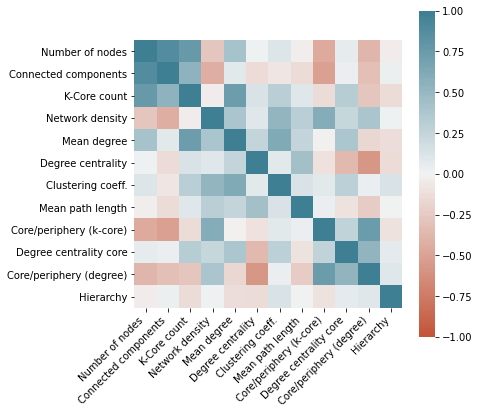

In [399]:
import seaborn as sns
from heatmap import heatmap, corrplot

fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [329]:
df_1.columns = ['Regularity', 'Change size', 'Number of nodes',
       'Network density', 'Mean degree',
       'Degree centrality', 'Clustering coeff.',
       'Mean path length', 'Core/periphery (k-core)',
       'Core/periphery (degree)', 'Hierarchy']